In [2]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random as rnd
from glob import glob
from tqdm import tqdm
import os

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'

from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

# Load Weizmann Data

In [38]:
datadir = "/home/ephy/Projects/tda_convolve_video/data/original/weizman/"

In [39]:
classes = os.listdir(datadir)

In [40]:
videos = []
y = []
for c in classes:
    d = os.listdir(datadir + c)
    for f in d:
        y.append(c)
        videos.append(f)
weizmann_labels=np.array(y)

In [134]:
imageSize=np.array([90,60])
videos = [(videos[i],y[i]) for i in range(len(y))]

In [42]:
# # storing the frames from training videos
# all_image = []
# for (video,clss) in tqdm(videos):
#     count = 0
#     cap = cv2.VideoCapture(datadir+clss+'/'+video)   # capturing the video from the given path
#     frameRate = 1 
#     frames = []
#     while(cap.isOpened()):
#         frameId = cap.get(1) #current frame number
#         ret, frame = cap.read()
#         if (ret != True):
#             break
#         if (frameId % math.floor(frameRate) == 0):
#             frames.append(frame)
#             count+=1
#     cap.release()
#     frames = np.stack(frames)
#     clip = []
#     print(frames.shape)
#     for f in range(0,23):
#         image = frames[f]
#         image = Image.fromarray(image , 'RGB')
#         image = image.resize(imageSize)
#         image = np.array(image)/255
#         image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#         clip.append(image)
#     all_image.append(clip)
# all_image = np.stack(all_image)    

In [43]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/weizmann_FFR_23frames.npy',all_image)
weiz_image=np.load('/home/ephy/Projects/tda_convolve_video/data/altered/weizmann_FFR_23frames.npy', allow_pickle=True)

In [115]:
weizmann_labels = np.array(pd.get_dummies(weizmann_labels))

# Load KTH Data

In [267]:
datadir = "/home/ephy/Projects/tda_convolve_video/data/original/KTH/"

In [268]:
classes = os.listdir(datadir)
classes = [c for c in classes if c!='scenes.txt']

In [269]:
f = open(datadir+'scenes.txt', "r")
scenes = []
for x in f:
    if '-' in x:
        parts = x.split('\t')
        name = parts[0].strip()+'_uncomp.avi'
        parts = parts[-1] 
        parts = parts.split(', ')
        starts = [part.split('-')[0] for part in parts]
        starts = np.array(starts, dtype=np.int)
        scenes.append((name,starts))

In [270]:
videos = []
y = []
for c in classes:
    d = os.listdir(datadir + c)
    for f in d:
        y.append(c)
        videos.append(f)
labels=np.array(y)

In [271]:
labels = np.repeat(labels, [len(scene[1]) for scene in scenes])
ds = [scene[0].split('_')[2] for scene in scenes for s in scene[1]]
len(ds)
persons = [scene[0].split('_')[0] for scene in scenes for s in scene[1]]
# nums = [str(i) for scene in scenes for i in range(len(scene[1]))]
stratLabels = [lab+d+person for (lab,d,person) in zip(labels,ds,persons)]

In [272]:
videos = [(videos[i],y[i]) for i in range(len(y))]

In [273]:
kth_image=np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_FFR_23frames.npy', allow_pickle=True)

# Merge Class system for inter-dataset testing

In [274]:
kth_to_weizmann_d ={
    'handwaving':'wave2',
    'running':'run',
    'walking':'walk'
}

In [275]:
kth_gen_labels = [kth_to_weizmann_d[label] if label in kth_to_weizmann_d.keys() else None for label in labels]

In [276]:
i,l,s = zip(*[(vid,label,stratLabel) for vid, label, stratLabel in zip(kth_image,kth_gen_labels,stratLabels) if label is not None])
kth_image = np.array(i)
kth_labels = np.array(pd.get_dummies(np.array(l)))
stratLabels = np.array(pd.get_dummies(np.array(s)))

## Testing and network functions

In [277]:
imageSize=(23,90,60)

In [278]:
def test(net, X, y, batchSize):
    confusionMatrix = np.zeros([101,101], dtype=np.int8)
    testingSeq = list(range(0,y.shape[0],batchSize))
    testingSeq.append(y.shape[0]+1)
    testingSeq = np.array(testingSeq)
    with torch.no_grad():
        for i in range(len(testingSeq)-1):
            data = X[testingSeq[i]:testingSeq[i+1]].view(-1,1,*imageSize).to(device)
            out = torch.argmax(net(data),axis=1).cpu()
            yt = torch.argmax(y[testingSeq[i]:testingSeq[i+1]],axis=1)
            for pred,label in zip(out,yt):
                confusionMatrix[label][pred] +=1
    del data
    del out
    del yt
    return confusionMatrix

In [279]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convRescale = nn.Conv3d(1, 20, (5,11,11), bias=False,stride=(1,3,3))
        self.conv1 = nn.Conv3d(20, 80, (5,11,11), stride=(1,2,2))
        self.conv2 = nn.Conv3d(80, 160, (3,9,4))
        
        self.batchConv1 = nn.BatchNorm3d(20)
        self.batchConv2 = nn.BatchNorm3d(80)
        self.batchConv3 = nn.BatchNorm3d(160)
        
        self.drop1=nn.Dropout3d(.2)
        self.drop2=nn.Dropout3d(.2)
                
        x= torch.randn(1,1,*imageSize)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 3)
        self.batch1 = nn.BatchNorm1d(3)
        
    def convs(self, x):
        x = F.leaky_relu(self.convRescale(x))
#         x = self.batchConv1(x)
        x = F.leaky_relu(self.conv1(x))
#         x = self.batchConv2(x)
#         x = self.drop1(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.batchConv3(x)
#         x = self.drop2(x)
#         print(x.shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
#             print(self._to_linear)
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc1(x)
        x = self.batch1(x)
        return F.softmax(x, dim=1)

In [280]:
net = Net().to(device)
torch.cuda.memory_allocated()*1e-9

0.275515392

In [281]:
filters = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot20.npy', allow_pickle=True)

In [307]:
EPOCHS = 200
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=100
trainingBatchSize=100
results = [[],[],[]]
genResults = [[],[],[]]
lossrec = [[],[],[]]

for foldIndex in range(3):

    net = Net().to(device)
    optimizer = optim.AdamW(net.parameters(), lr=3e-3)

    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(filters):
            net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
        net.convRescale.requires_grad=False

    print('Network Reset.')  

    X_train, X_test, y_train, y_test = train_test_split(kth_image, kth_labels,
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=.1, stratify = stratLabels)
    # Just use this for shuffling
    

    X_train = torch.tensor(X_train,dtype=torch.float32)
    y_train = torch.tensor(y_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_test = torch.tensor(y_test,dtype=torch.float32)
    gX_test =  torch.tensor(weiz_image,dtype=torch.float32)
    gy_test = torch.tensor(weizmann_labels,dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,*imageSize)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        genResults[foldIndex].append(test(net, gX_test, gy_test, testingBatchSize))
#         cm = results[foldIndex][len(results[foldIndex])-1]
#         print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_res.npy', results)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_loss.npy', lossrec)

Network Reset.
Fold:  0 Epoch:  0
Fold:  0 Epoch:  1
Fold:  0 Epoch:  2
Fold:  0 Epoch:  3
Fold:  0 Epoch:  4
Fold:  0 Epoch:  5
Fold:  0 Epoch:  6
Fold:  0 Epoch:  7
Fold:  0 Epoch:  8
Fold:  0 Epoch:  9
Fold:  0 Epoch:  10
Fold:  0 Epoch:  11
Fold:  0 Epoch:  12
Fold:  0 Epoch:  13
Fold:  0 Epoch:  14
Fold:  0 Epoch:  15
Fold:  0 Epoch:  16
Fold:  0 Epoch:  17
Fold:  0 Epoch:  18
Fold:  0 Epoch:  19
Fold:  0 Epoch:  20
Fold:  0 Epoch:  21
Fold:  0 Epoch:  22
Fold:  0 Epoch:  23
Fold:  0 Epoch:  24
Fold:  0 Epoch:  25
Fold:  0 Epoch:  26
Fold:  0 Epoch:  27
Fold:  0 Epoch:  28
Fold:  0 Epoch:  29
Fold:  0 Epoch:  30
Fold:  0 Epoch:  31
Fold:  0 Epoch:  32
Fold:  0 Epoch:  33
Fold:  0 Epoch:  34
Fold:  0 Epoch:  35
Fold:  0 Epoch:  36
Fold:  0 Epoch:  37
Fold:  0 Epoch:  38
Fold:  0 Epoch:  39
Fold:  0 Epoch:  40
Fold:  0 Epoch:  41
Fold:  0 Epoch:  42
Fold:  0 Epoch:  43
Fold:  0 Epoch:  44
Fold:  0 Epoch:  45
Fold:  0 Epoch:  46
Fold:  0 Epoch:  47
Fold:  0 Epoch:  48
Fold:  0 Epoch:

Fold:  2 Epoch:  0
Fold:  2 Epoch:  1
Fold:  2 Epoch:  2
Fold:  2 Epoch:  3
Fold:  2 Epoch:  4
Fold:  2 Epoch:  5
Fold:  2 Epoch:  6
Fold:  2 Epoch:  7
Fold:  2 Epoch:  8
Fold:  2 Epoch:  9
Fold:  2 Epoch:  10
Fold:  2 Epoch:  11
Fold:  2 Epoch:  12
Fold:  2 Epoch:  13
Fold:  2 Epoch:  14
Fold:  2 Epoch:  15
Fold:  2 Epoch:  16
Fold:  2 Epoch:  17
Fold:  2 Epoch:  18
Fold:  2 Epoch:  19
Fold:  2 Epoch:  20
Fold:  2 Epoch:  21
Fold:  2 Epoch:  22
Fold:  2 Epoch:  23
Fold:  2 Epoch:  24
Fold:  2 Epoch:  25
Fold:  2 Epoch:  26
Fold:  2 Epoch:  27
Fold:  2 Epoch:  28
Fold:  2 Epoch:  29
Fold:  2 Epoch:  30
Fold:  2 Epoch:  31
Fold:  2 Epoch:  32
Fold:  2 Epoch:  33
Fold:  2 Epoch:  34
Fold:  2 Epoch:  35
Fold:  2 Epoch:  36
Fold:  2 Epoch:  37
Fold:  2 Epoch:  38
Fold:  2 Epoch:  39
Fold:  2 Epoch:  40
Fold:  2 Epoch:  41
Fold:  2 Epoch:  42
Fold:  2 Epoch:  43
Fold:  2 Epoch:  44
Fold:  2 Epoch:  45
Fold:  2 Epoch:  46
Fold:  2 Epoch:  47
Fold:  2 Epoch:  48
Fold:  2 Epoch:  49
Fold:  2 E

In [308]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_kl1_res.npy', results)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_kl1_genRes.npy', genResults)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_kl1_loss.npy', lossrec)

In [328]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convRescale = nn.Conv3d(1, 20, (5,11,11), bias=True,stride=(1,3,3))
        self.conv1 = nn.Conv3d(20, 80, (5,11,11), stride=(1,2,2))
        self.conv2 = nn.Conv3d(80, 160, (3,9,4))
        
        self.batchConv1 = nn.BatchNorm3d(20)
        self.batchConv2 = nn.BatchNorm3d(80)
        self.batchConv3 = nn.BatchNorm3d(160)
        
        self.drop1=nn.Dropout3d(.2)
        self.drop2=nn.Dropout3d(.2)
                
        x= torch.randn(1,1,*imageSize)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 3)
        self.batch1 = nn.BatchNorm1d(3)
        
    def convs(self, x):
        x = F.leaky_relu(self.convRescale(x))
#         x = self.batchConv1(x)
        x = F.leaky_relu(self.conv1(x))
#         x = self.batchConv2(x)
#         x = self.drop1(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.batchConv3(x)
#         x = self.drop2(x)
#         print(x.shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
#             print(self._to_linear)
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc1(x)
        x = self.batch1(x)
        return F.softmax(x, dim=1)

In [15]:
EPOCHS = 200
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=100
trainingBatchSize=100
results = [[],[],[]]
genResults = [[],[],[]]
lossrec = [[],[],[]]

for foldIndex in range(3):

    net = Net().to(device)
    optimizer = optim.AdamW(net.parameters(), lr=3e-3)

#     # Set filters in 2 layers
#     with torch.no_grad():
#         for i,weights in enumerate(filters):
#             net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
#         net.convRescale.requires_grad=False

    print('Network Reset.')  

    X_train, X_test, y_train, y_test = train_test_split(kth_image, kth_labels,
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=.1, stratify = stratLabels)
    # Just use this for shuffling
    

    X_train = torch.tensor(X_train,dtype=torch.float32)
    y_train = torch.tensor(y_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_test = torch.tensor(y_test,dtype=torch.float32)
    gX_test =  torch.tensor(weiz_image,dtype=torch.float32)
    gy_test = torch.tensor(weizmann_labels,dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,*imageSize)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        genResults[foldIndex].append(test(net, gX_test, gy_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_res.npy', results)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_net8_k1layer_30_loss.npy', lossrec)

NameError: name 'Net' is not defined

In [330]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_norm_res.npy', results)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_norm_genRes.npy', genResults)
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_norm_loss.npy', lossrec)

In [3]:
results = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_norm_res.npy')
genResults = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_norm_genRes.npy')
loss = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_norm_loss.npy')
results_kl = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_kl1_res.npy')
genResults_kl = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_kl1_genRes.npy')
loss_kl = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH2weizmn_kl1_loss.npy')

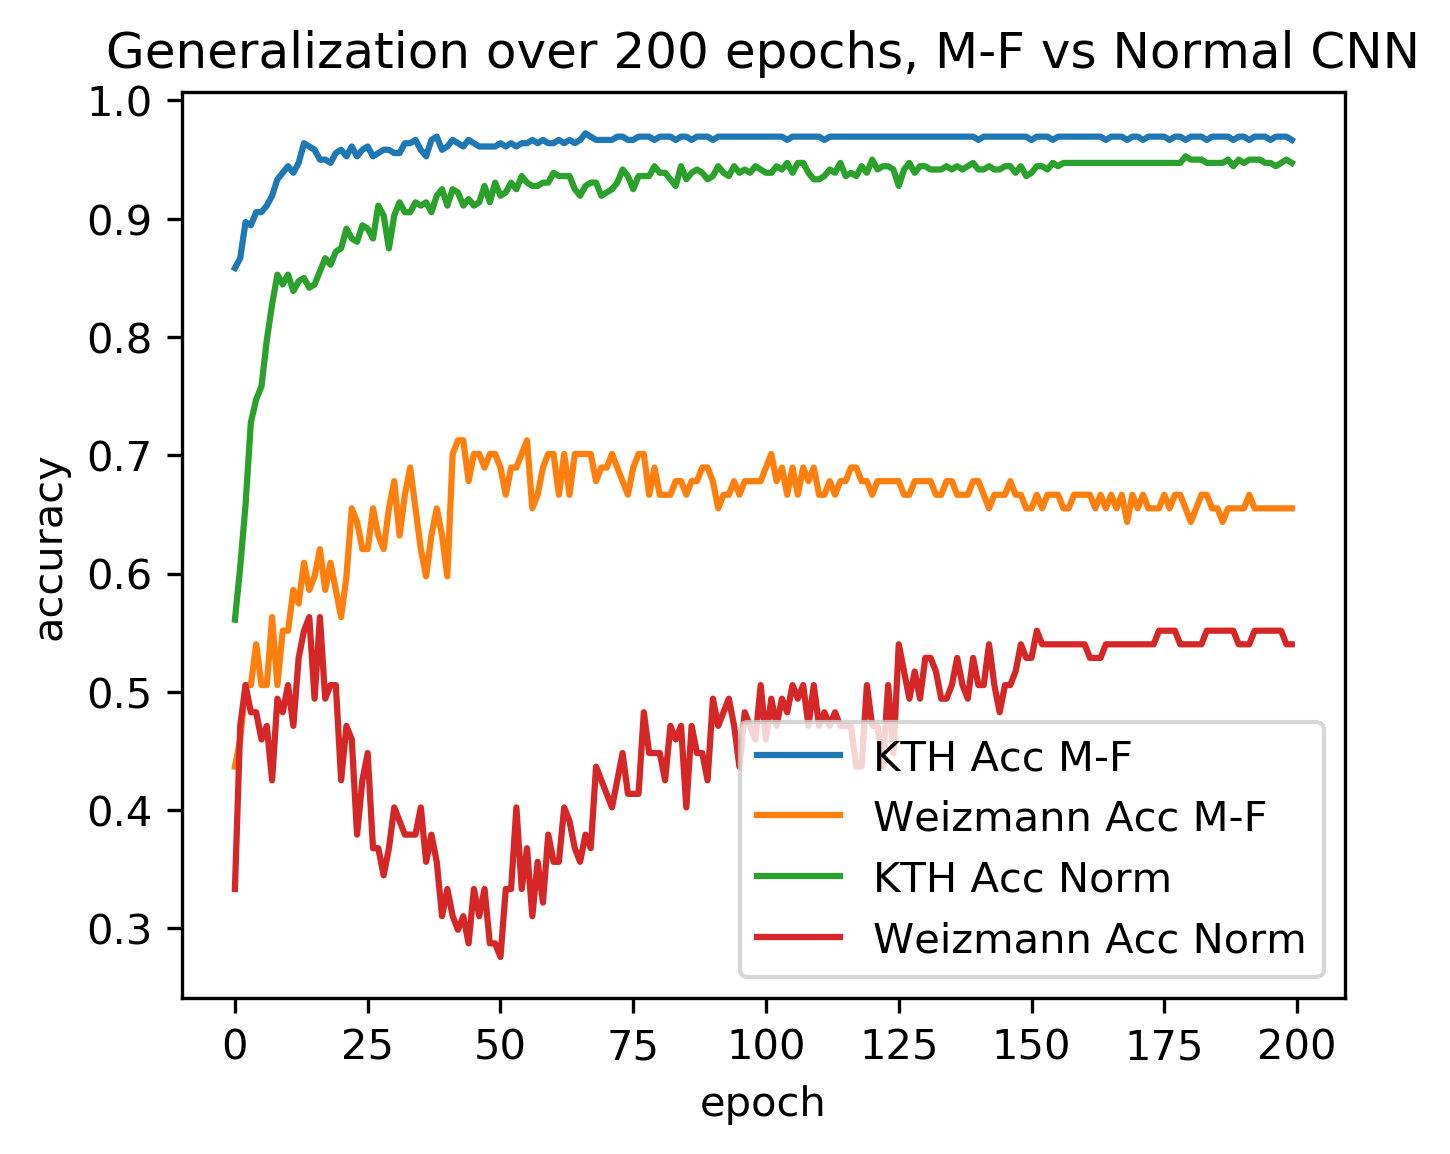

In [4]:
kresults=[[]]*3
for i in range(3):
    kresults[i] = [np.sum(np.diag(cm))/np.sum(cm) for cm in results[i]]
kresults = np.mean(np.array(kresults),axis=0)

wresults=[[]]*3
for i in range(3):
    wresults[i] = [np.sum(np.diag(cm))/np.sum(cm) for cm in genResults[i]]
wresults = np.mean(np.array(wresults),axis=0)

kresults_kl=[[]]*3
for i in range(3):
    kresults_kl[i] = [np.sum(np.diag(cm))/np.sum(cm) for cm in results_kl[i]]
kresults_kl = np.mean(np.array(kresults_kl),axis=0)

wresults_kl=[[]]*3
for i in range(3):
    wresults_kl[i] = [np.sum(np.diag(cm))/np.sum(cm) for cm in genResults_kl[i]]
wresults_kl = np.mean(np.array(wresults_kl),axis=0)
fig = plt.figure(figsize=(5,4),dpi=300)
plt.plot(kresults_kl, label='KTH Acc M-F')
plt.plot(wresults_kl, label='Weizmann Acc M-F')
plt.plot(kresults, label='KTH Acc Norm')
plt.plot(wresults, label='Weizmann Acc Norm')
plt.legend()
plt.title('Generalization over 200 epochs, M-F vs Normal CNN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [14]:
kresults=[[]]*3
for i in range(3):
    kresults[i] = [np.sum(np.diag(cm))/np.sum(cm) for cm in results[i]]
np.max(np.mean(np.array(kresults_kl),axis=0))

0.9631250000000001